In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import tqdm 
import optuna
import joblib

# Preprocessing
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import numpy as np
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder


In [147]:
orders = pd.read_csv('olist_orders_dataset.csv')
order_payments = pd.read_csv('olist_order_payments_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
order_reviews
# Merge the datasets based on the order_id column
merged = orders.merge(order_payments, on='order_id')
merged = merged.merge(order_items, on='order_id')
merged = merged.merge(products, on='product_id')
merged = merged.merge(sellers, on='seller_id')
merged = merged.merge(customers, on='customer_id')
merged = merged.merge(order_reviews, on='order_id')

In [148]:
merged.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

In [149]:
# Extract the relevant features from the merged dataset
merged_features = merged[['price','payment_type', 'payment_value', 'product_category_name',
                     'product_weight_g', 'product_height_cm', 
                     'seller_state', 'customer_state', 'payment_installments','freight_value']]



merged_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117329 entries, 0 to 117328
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   price                  117329 non-null  float64
 1   payment_type           117329 non-null  object 
 2   payment_value          117329 non-null  float64
 3   product_category_name  115634 non-null  object 
 4   product_weight_g       117309 non-null  float64
 5   product_height_cm      117309 non-null  float64
 6   seller_state           117329 non-null  object 
 7   customer_state         117329 non-null  object 
 8   payment_installments   117329 non-null  int64  
 9   freight_value          117329 non-null  float64
dtypes: float64(5), int64(1), object(4)
memory usage: 9.8+ MB


In [150]:
merged_features = merged_features.dropna()

In [151]:
merged_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115633 entries, 0 to 117328
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   price                  115633 non-null  float64
 1   payment_type           115633 non-null  object 
 2   payment_value          115633 non-null  float64
 3   product_category_name  115633 non-null  object 
 4   product_weight_g       115633 non-null  float64
 5   product_height_cm      115633 non-null  float64
 6   seller_state           115633 non-null  object 
 7   customer_state         115633 non-null  object 
 8   payment_installments   115633 non-null  int64  
 9   freight_value          115633 non-null  float64
dtypes: float64(5), int64(1), object(4)
memory usage: 9.7+ MB


In [152]:
# Handle missing values
## very less data is missing so we are removing the data
#imputer = SimpleImputer(strategy='mean')
#merged_features[['payment_value', 'product_weight_g',  'product_height_cm']] = imputer.fit_transform(merged_features[['payment_value', 'product_weight_g', 'product_height_cm', 'product_width_cm']])

# Encode categorical variables
cat_features = [ 'product_category_name', 'seller_state', 'customer_state']
le = LabelEncoder()

tenc=ce.TargetEncoder() 
product_cat = tenc.fit_transform(merged_features[cat_features],merged_features['payment_installments'])


In [153]:
merged_features = merged_features.drop(columns=['product_category_name', 'seller_state', 'customer_state'])

# Add the one-hot encoded columns to the original DataFrame
merged_features = pd.concat([merged_features, product_cat], axis=1)
merged_features

,price,payment_type,payment_value,product_weight_g,product_height_cm,payment_installments,freight_value,product_category_name,seller_state,customer_state
0,29.99,credit_card,18.12,500.0,8.0,1,8.72,2.972719,2.883846,2.717388
1,29.99,voucher,2.00,500.0,8.0,1,8.72,2.972719,2.883846,2.717388
2,29.99,voucher,18.59,500.0,8.0,1,8.72,2.972719,2.883846,2.717388
3,29.99,credit_card,37.77,500.0,8.0,3,7.78,2.972719,2.883846,2.717388
4,29.99,credit_card,37.77,500.0,8.0,1,7.78,2.972719,2.883846,2.717388
...,...,...,...,...,...,...,...,...,...,...
117324,79.00,boleto,93.13,750.0,28.0,1,14.13,2.934426,2.883846,2.717388
117325,19.70,credit_card,30.66,400.0,4.0,1,10.96,2.887282,3.354892,2.963727
117326,399.00,debit_card,444.07,2100.0,8.0,1,45.07,3.125357,2.883846,3.625409
117327,219.90,credit_card,244.02,5900.0,21.0,4,24.12,3.125357,2.883846,3.062756


In [154]:
## handeling one-hot encoding for payment type

one_hot = pd.get_dummies(merged_features['payment_type'],prefix='payment_type')
print(one_hot)
# merged_feature = merged_features.drop('payment_type', axis=1, inplace=True)

# # Add the one-hot encoded columns to the original DataFrame
# merged_features = pd.concat([merged_features, one_hot], axis=1)


        payment_type_boleto  payment_type_credit_card  \
0                         0                         1   
1                         0                         0   
2                         0                         0   
3                         0                         1   
4                         0                         1   
...                     ...                       ...   
117324                    1                         0   
117325                    0                         1   
117326                    0                         0   
117327                    0                         1   
117328                    1                         0   

        payment_type_debit_card  payment_type_voucher  
0                             0                     0  
1                             0                     1  
2                             0                     1  
3                             0                     0  
4                             0    

In [155]:
merged_feature = merged_features.drop('payment_type', axis=1, inplace=True)

# # Add the one-hot encoded columns to the original DataFrame
merged_features = pd.concat([merged_features, one_hot], axis=1)

In [156]:
merged_features.columns

Index(['price', 'payment_value', 'product_weight_g', 'product_height_cm',
       'payment_installments', 'freight_value', 'product_category_name',
       'seller_state', 'customer_state', 'payment_type_boleto',
       'payment_type_credit_card', 'payment_type_debit_card',
       'payment_type_voucher'],
      dtype='object')

In [157]:
final_df = merged_features

In [158]:
final_df

,price,payment_value,product_weight_g,product_height_cm,payment_installments,freight_value,product_category_name,seller_state,customer_state,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher
0,29.99,18.12,500.0,8.0,1,8.72,2.972719,2.883846,2.717388,0,1,0,0
1,29.99,2.00,500.0,8.0,1,8.72,2.972719,2.883846,2.717388,0,0,0,1
2,29.99,18.59,500.0,8.0,1,8.72,2.972719,2.883846,2.717388,0,0,0,1
3,29.99,37.77,500.0,8.0,3,7.78,2.972719,2.883846,2.717388,0,1,0,0
4,29.99,37.77,500.0,8.0,1,7.78,2.972719,2.883846,2.717388,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117324,79.00,93.13,750.0,28.0,1,14.13,2.934426,2.883846,2.717388,1,0,0,0
117325,19.70,30.66,400.0,4.0,1,10.96,2.887282,3.354892,2.963727,0,1,0,0
117326,399.00,444.07,2100.0,8.0,1,45.07,3.125357,2.883846,3.625409,0,0,1,0
117327,219.90,244.02,5900.0,21.0,4,24.12,3.125357,2.883846,3.062756,0,1,0,0


In [159]:
# Scale numerical variables
#'price', 'payment_value', 'product_weight_g', 'product_height_cm','payment_installments', 'freight_value', 'product_category_name',
#       'seller_state', 'customer_state', 'payment_type_boleto',
#       'payment_type_credit_card', 'payment_type_debit_card','payment_type_voucher'
num_features = ['payment_value',  'product_weight_g',  'freight_value',
                'product_height_cm', 'seller_state', 'customer_state', 'product_category_name']
scaler = StandardScaler()
merged_features[num_features] = scaler.fit_transform(merged_features[num_features])


In [160]:
final_df = merged_features

In [161]:
merged_features 

,price,payment_value,product_weight_g,product_height_cm,payment_installments,freight_value,product_category_name,seller_state,customer_state,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher
0,29.99,-0.580315,-0.426808,-0.641280,1,-0.715900,0.050805,-0.369792,-0.935604,0,1,0,0
1,29.99,-0.640953,-0.426808,-0.641280,1,-0.715900,0.050805,-0.369792,-0.935604,0,0,0,1
2,29.99,-0.578547,-0.426808,-0.641280,1,-0.715900,0.050805,-0.369792,-0.935604,0,0,0,1
3,29.99,-0.506398,-0.426808,-0.641280,3,-0.775261,0.050805,-0.369792,-0.935604,0,1,0,0
4,29.99,-0.506398,-0.426808,-0.641280,1,-0.775261,0.050805,-0.369792,-0.935604,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117324,79.00,-0.298153,-0.360697,0.843197,1,-0.374257,-0.023393,-0.369792,-0.935604,1,0,0,0
117325,19.70,-0.533144,-0.453252,-0.938175,1,-0.574443,-0.114743,2.470949,0.072504,0,1,0,0
117326,399.00,1.021965,-0.003700,-0.641280,1,1.579612,0.346569,-0.369792,2.780352,0,0,1,0
117327,219.90,0.269444,1.001183,0.323630,4,0.256614,0.346569,-0.369792,0.477767,0,1,0,0


### removing outliers 

In [162]:
merged_features.payment_installments.value_counts()

1     57616
2     13405
3     11555
4      7855
10     6785
5      5928
8      5014
6      4547
7      1789
9       710
12      164
15       91
18       38
24       34
11       22
20       20
13       19
14       16
17        7
16        7
21        6
0         3
23        1
22        1
Name: payment_installments, dtype: int64

In [163]:
merged_features = merged_features[merged_features['payment_installments'] != 7]
merged_features = merged_features[merged_features['payment_installments'] != 9]

In [164]:
merged_features = merged_features[merged_features['payment_installments'] <= 10]

In [165]:
merged_features = merged_features[merged_features['payment_installments'] != 0]

In [166]:
merged_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112705 entries, 0 to 117328
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   price                     112705 non-null  float64
 1   payment_value             112705 non-null  float64
 2   product_weight_g          112705 non-null  float64
 3   product_height_cm         112705 non-null  float64
 4   payment_installments      112705 non-null  int64  
 5   freight_value             112705 non-null  float64
 6   product_category_name     112705 non-null  float64
 7   seller_state              112705 non-null  float64
 8   customer_state            112705 non-null  float64
 9   payment_type_boleto       112705 non-null  uint8  
 10  payment_type_credit_card  112705 non-null  uint8  
 11  payment_type_debit_card   112705 non-null  uint8  
 12  payment_type_voucher      112705 non-null  uint8  
dtypes: float64(8), int64(1), uint8(4)
memory usa

In [167]:
merged_features = merged_features.dropna()

In [168]:
merged_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112705 entries, 0 to 117328
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   price                     112705 non-null  float64
 1   payment_value             112705 non-null  float64
 2   product_weight_g          112705 non-null  float64
 3   product_height_cm         112705 non-null  float64
 4   payment_installments      112705 non-null  int64  
 5   freight_value             112705 non-null  float64
 6   product_category_name     112705 non-null  float64
 7   seller_state              112705 non-null  float64
 8   customer_state            112705 non-null  float64
 9   payment_type_boleto       112705 non-null  uint8  
 10  payment_type_credit_card  112705 non-null  uint8  
 11  payment_type_debit_card   112705 non-null  uint8  
 12  payment_type_voucher      112705 non-null  uint8  
dtypes: float64(8), int64(1), uint8(4)
memory usa

In [169]:
final_df = merged_features

## Model Building

In [171]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(merged_features.drop(columns=['payment_installments']),merged_features.payment_installments, test_size=0.20, stratify = merged_features.payment_installments, random_state=42)

In [172]:
# Define models to be trained
models = {
    "Logistic Regression": LogisticRegression(max_iter=3000,solver="liblinear"),
    
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boost": GradientBoostingClassifier(),
    "Support Vector Machine": SVC()
}

# Define number of samples to use for cross-validation
n_samples = 10000

# Create stratified folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# Create empty dictionaries to store accuracy and f1 scores for each model
train_df_accuracy_scores = {}
train_df_f1_scores = {}
train_df_classification_reports = {}

In [173]:
# Loop through models and perform cross-validation
for name, model in tqdm(models.items()):
    # Create pipeline
    pipeline = make_pipeline( model)
    
    # Perform cross-validation on subset of data
    scores = cross_validate(pipeline, X_train[:n_samples], y_train[:n_samples], cv=skf, n_jobs=-1, scoring=["accuracy", "f1_macro"], return_train_score=False)
    
    # Calculate mean and standard deviation of scores
    mean_accuracy = np.mean(scores['test_accuracy'])
    std_accuracy = np.std(scores['test_accuracy'])
    mean_f1_score = np.mean(scores['test_f1_macro'])
    std_f1_score = np.std(scores['test_f1_macro'])
    
    # Store accuracy and f1 scores for each model
    train_df_accuracy_scores[name] = (mean_accuracy, std_accuracy)
    train_df_f1_scores[name] = (mean_f1_score, std_f1_score)
    
    # Store classification report for each model
    pipeline.fit(X_train[:n_samples], y_train[:n_samples])
    y_pred = pipeline.predict(X_train[:n_samples])
    train_df_classification_reports[name] = classification_report(y_train[:n_samples], y_pred)
    
    # Print results
    print(f"{name}:")
    print(f"\tAccuracy: {mean_accuracy:.3f} +/- {std_accuracy:.3f}")
    print(f"\tF1-score: {mean_f1_score:.3f} +/- {std_f1_score:.3f}")

  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 20%|██        | 1

Logistic Regression:
	Accuracy: 0.526 +/- 0.003
	F1-score: 0.146 +/- 0.004


 40%|████      | 2/5 [00:10<00:13,  4.67s/it]

Decision Tree:
	Accuracy: 0.484 +/- 0.008
	F1-score: 0.265 +/- 0.010


 60%|██████    | 3/5 [00:15<00:09,  4.99s/it]

Random Forest:
	Accuracy: 0.534 +/- 0.005
	F1-score: 0.271 +/- 0.009


 80%|████████  | 4/5 [00:49<00:16, 16.35s/it]

Gradient Boost:
	Accuracy: 0.542 +/- 0.003
	F1-score: 0.247 +/- 0.004


 80%|████████  | 4/5 [00:53<00:13, 13.35s/it]


KeyboardInterrupt: 

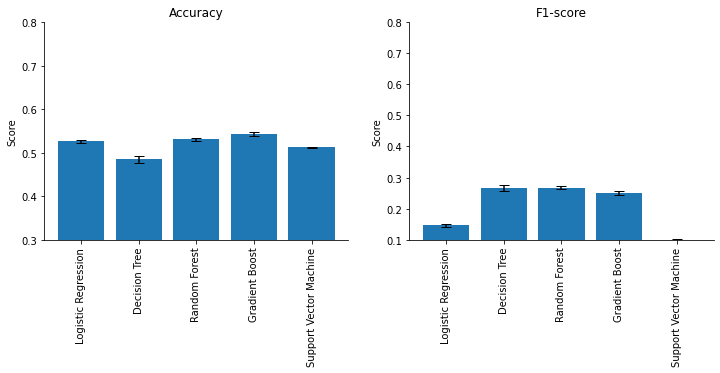

In [96]:
# Plot accuracy and f1-score for each model
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# Plot accuracy
ax[0].bar(train_df_accuracy_scores.keys(), [score[0] for score in train_df_accuracy_scores.values()], yerr=[score[1] for score in train_df_accuracy_scores.values()], capsize=5)
ax[0].set_ylim([0.3, 0.80])
ax[0].set_title("Accuracy")
ax[0].set_ylabel("Score")
ax[0].tick_params(axis='x', labelrotation=90)

# Plot f1-score
ax[1].bar(train_df_f1_scores.keys(), [score[0] for score in train_df_f1_scores.values()], yerr=[score[1] for score in train_df_f1_scores.values()], capsize=5)
ax[1].set_ylim([0.1, 0.80])
ax[1].set_title("F1-score")
ax[1].set_ylabel("Score")
ax[1].tick_params(axis='x', labelrotation=90)

# Remove right borders
ax[0].spines['right'].set_visible(False)
ax[1].spines['right'].set_visible(False)

ax[0].spines['top'].set_visible(False)
ax[1].spines['top'].set_visible(False)

plt.show()

## payment prediction

In [174]:
import datetime as dt

In [175]:
orders = pd.read_csv('olist_orders_dataset.csv')
order_payments = pd.read_csv('olist_order_payments_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
order_reviews
# Merge the datasets based on the order_id column
merged_2 = orders.merge(order_payments, on='order_id')
merged_2 = merged_2.merge(order_items, on='order_id')
merged_2 = merged_2.merge(products, on='product_id')
merged_2 = merged_2.merge(sellers, on='seller_id')
merged_2 = merged_2.merge(customers, on='customer_id')
merged_2 = merged_2.merge(order_reviews, on='order_id')

In [176]:
merged_2['order_purchase_timestamp'] = pd.to_datetime(merged_2['order_purchase_timestamp'])
merged_2['order_approved_at'] = pd.to_datetime(merged_2['order_approved_at'])
merged_2['order_delivered_carrier_date'] = pd.to_datetime(merged_2['order_delivered_carrier_date'])
merged_2['order_delivered_customer_date'] = pd.to_datetime(merged_2['order_delivered_customer_date'])
merged_2['order_estimated_delivery_date'] = pd.to_datetime(merged_2['order_estimated_delivery_date'])
merged_2["delivery_duration"] = (merged_2["order_delivered_customer_date"] - merged_2["order_delivered_carrier_date"])
merged_2["delivery_hours"] = merged_2["delivery_duration"]/ dt.timedelta(hours=1)

<AxesSubplot:>

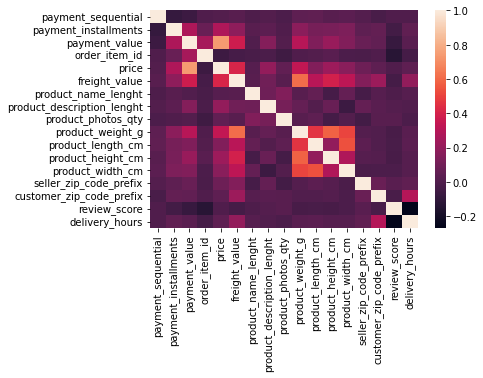

In [177]:
sns.heatmap(merged_2.corr())

delivery_hours        93997 non-null  float64
 1   price                 93997 non-null  float64
 2   freight_value         93997 non-null  float64
 3   review_score          93997 non-null  float64
 4   payment_sequential    93997 non-null  float64
 5   payment_installments  93997 non-null  float64
 6   payment_value         93997 non-null  float64
 7   product_weight_g      93997 non-null  float64
 8   product_length_cm     93997 non-null  float64
 9   product_height_cm     93997 non-null  float64
 10  product_width_cm 

In [194]:
price_df = merged_2[['price','freight_value', 'review_score','payment_sequential','payment_installments',
                     'payment_value','product_weight_g','product_length_cm','product_height_cm','product_width_cm']]

In [195]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117329 entries, 0 to 117328
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   price                 117329 non-null  float64
 1   freight_value         117329 non-null  float64
 2   review_score          117329 non-null  int64  
 3   payment_sequential    117329 non-null  int64  
 4   payment_installments  117329 non-null  int64  
 5   payment_value         117329 non-null  float64
 6   product_weight_g      117309 non-null  float64
 7   product_length_cm     117309 non-null  float64
 8   product_height_cm     117309 non-null  float64
 9   product_width_cm      117309 non-null  float64
dtypes: float64(7), int64(3)
memory usage: 9.8 MB


In [196]:
price_df = price_df.dropna()

In [197]:
price_df

,price,freight_value,review_score,payment_sequential,payment_installments,payment_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,29.99,8.72,4,1,1,18.12,500.0,19.0,8.0,13.0
1,29.99,8.72,4,3,1,2.00,500.0,19.0,8.0,13.0
2,29.99,8.72,4,2,1,18.59,500.0,19.0,8.0,13.0
3,29.99,7.78,4,1,3,37.77,500.0,19.0,8.0,13.0
4,29.99,7.78,5,1,1,37.77,500.0,19.0,8.0,13.0
...,...,...,...,...,...,...,...,...,...,...
117324,79.00,14.13,5,1,1,93.13,750.0,30.0,28.0,28.0
117325,19.70,10.96,1,1,1,30.66,400.0,16.0,4.0,11.0
117326,399.00,45.07,5,1,1,444.07,2100.0,80.0,8.0,30.0
117327,219.90,24.12,4,1,4,244.02,5900.0,41.0,21.0,41.0


In [198]:
num_features_price = ['price', 'freight_value',  'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']
scaler = StandardScaler()
price_df[num_features_price] = scaler.fit_transform(price_df[num_features_price])

In [199]:
price_df

,price,freight_value,review_score,payment_sequential,payment_installments,payment_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,-0.495042,-0.714399,4,1,1,18.12,-0.425552,-0.695688,-0.640211,-0.857450
1,-0.495042,-0.714399,4,3,1,2.00,-0.425552,-0.695688,-0.640211,-0.857450
2,-0.495042,-0.714399,4,2,1,18.59,-0.425552,-0.695688,-0.640211,-0.857450
3,-0.495042,-0.773784,4,1,3,37.77,-0.425552,-0.695688,-0.640211,-0.857450
4,-0.495042,-0.773784,5,1,1,37.77,-0.425552,-0.695688,-0.640211,-0.857450
...,...,...,...,...,...,...,...,...,...,...
117324,-0.227052,-0.372625,5,1,1,93.13,-0.359504,-0.015729,0.846494,0.419600
117325,-0.551309,-0.572888,1,1,1,30.66,-0.451971,-0.881131,-0.937552,-1.027723
117326,1.522733,1.581997,5,1,1,444.07,-0.002844,3.074993,-0.640211,0.589873
117327,0.543401,0.258489,4,1,4,244.02,1.001090,0.664230,0.326148,1.526376


In [280]:
price_df = price_df[price_df['payment_value'] <= 500]

In [281]:
final_price_df = price_df

In [282]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111217 entries, 0 to 117328
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   price                 111217 non-null  float64
 1   freight_value         111217 non-null  float64
 2   review_score          111217 non-null  int64  
 3   payment_sequential    111217 non-null  int64  
 4   payment_installments  111217 non-null  int64  
 5   payment_value         111217 non-null  float64
 6   product_weight_g      111217 non-null  float64
 7   product_length_cm     111217 non-null  float64
 8   product_height_cm     111217 non-null  float64
 9   product_width_cm      111217 non-null  float64
dtypes: float64(7), int64(3)
memory usage: 9.3 MB


#### model 

In [201]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(price_df.drop(columns=['payment_value']),price_df.payment_value, test_size=0.20,  random_state=42)

In [186]:
# # Define models to be trained
# models = {
#     "Logistic Regression": LogisticRegression(max_iter=3000,solver="liblinear"),
    
#     "Decision Tree": DecisionTreeClassifier(),
#     "Random Forest": RandomForestClassifier(),
#     "Gradient Boost": GradientBoostingClassifier(),
#     "Support Vector Machine": SVC()
# }

# # Define number of samples to use for cross-validation
# n_samples = 10000

# # Create stratified folds
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# # Create empty dictionaries to store accuracy and f1 scores for each model
# train_df_accuracy_scores = {}
# train_df_f1_scores = {}
# train_df_classification_reports = {}

In [283]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


# define a list of regression models to try
models = {
    "Linear Regression":LinearRegression(),
    "Ridge":Ridge(alpha=0.5),
    "Lasso":Lasso(alpha=0.1),
    "ElasticNet":ElasticNet(alpha=0.1, l1_ratio=0.5),
    "Random Forest Regression":RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "Gradient Boosting":GradientBoostingRegressor(n_estimators=100, max_depth=10, random_state=42)
}





In [284]:
models

{'Linear Regression': LinearRegression(),
 'Ridge': Ridge(alpha=0.5),
 'Lasso': Lasso(alpha=0.1),
 'ElasticNet': ElasticNet(alpha=0.1),
 'Random Forest Regression': RandomForestRegressor(max_depth=10, random_state=42),
 'Gradient Boosting': GradientBoostingRegressor(max_depth=10, random_state=42)}

In [285]:
models.values()

dict_values([LinearRegression(), Ridge(alpha=0.5), Lasso(alpha=0.1), ElasticNet(alpha=0.1), RandomForestRegressor(max_depth=10, random_state=42), GradientBoostingRegressor(max_depth=10, random_state=42)])

In [286]:
for i in models.items():
    print(i[1])

LinearRegression()
Ridge(alpha=0.5)
Lasso(alpha=0.1)
ElasticNet(alpha=0.1)
RandomForestRegressor(max_depth=10, random_state=42)
GradientBoostingRegressor(max_depth=10, random_state=42)


In [287]:
# Define a dictionary to store the metrics for each model
metrics = {}


for name, model in tqdm(models.items(), desc='Fitting models', unit='model'):
    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Compute the metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Save the metrics in the dictionary
    metrics[name] = {'MAE': mae, 'MSE': mse, 'R2': r2}

    print(model)
    print(mae)
    print("MSE=",mse)
    print("r2=",r2)

    print("")



Fitting models:  50%|█████     | 3/6 [00:00<00:00, 28.97model/s]

LinearRegression()
57.83111881537815
MSE= 23172.907774198105
r2= 0.6219038233864207

Ridge(alpha=0.5)
57.83100904875404
MSE= 23172.889343997085
r2= 0.6219041240991585

Lasso(alpha=0.1)
57.8120988598567
MSE= 23170.94068070467
r2= 0.621935919079208

ElasticNet(alpha=0.1)
57.26105402874106
MSE= 23107.185881091977
r2= 0.6229761616853242



Fitting models:  83%|████████▎ | 5/6 [00:16<00:04,  4.09s/model]

RandomForestRegressor(max_depth=10, random_state=42)
50.32588652434112
MSE= 11201.047605561109
r2= 0.8172403172274785



Fitting models: 100%|██████████| 6/6 [00:41<00:00,  7.00s/model]

GradientBoostingRegressor(max_depth=10, random_state=42)
39.94647045835827
MSE= 7112.118837261988
r2= 0.8839565165410828



In [288]:
metrics

{'Linear Regression': {'MAE': 57.83111881537815,
  'MSE': 23172.907774198105,
  'R2': 0.6219038233864207},
 'Ridge': {'MAE': 57.83100904875404,
  'MSE': 23172.889343997085,
  'R2': 0.6219041240991585},
 'Lasso': {'MAE': 57.8120988598567,
  'MSE': 23170.94068070467,
  'R2': 0.621935919079208},
 'ElasticNet': {'MAE': 57.26105402874106,
  'MSE': 23107.185881091977,
  'R2': 0.6229761616853242},
 'Random Forest Regression': {'MAE': 50.32588652434112,
  'MSE': 11201.047605561109,
  'R2': 0.8172403172274785},
 'Gradient Boosting': {'MAE': 39.94647045835827,
  'MSE': 7112.118837261988,
  'R2': 0.8839565165410828}}

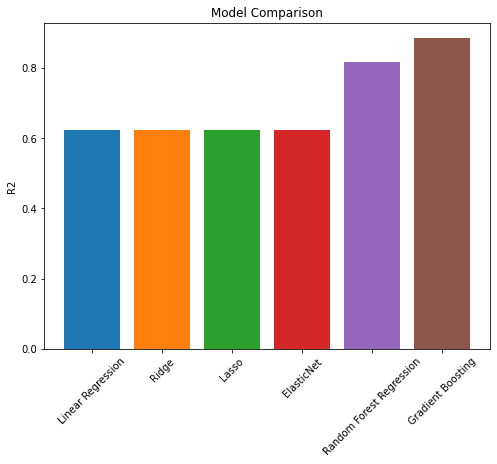

In [289]:
fig, ax = plt.subplots(figsize=(8, 6))
for name, metric in metrics.items():
    ax.bar(name, metric['R2'])
ax.set_ylabel('R2')
plt.xticks(rotation=45)
ax.set_title('Model Comparison')
plt.show()

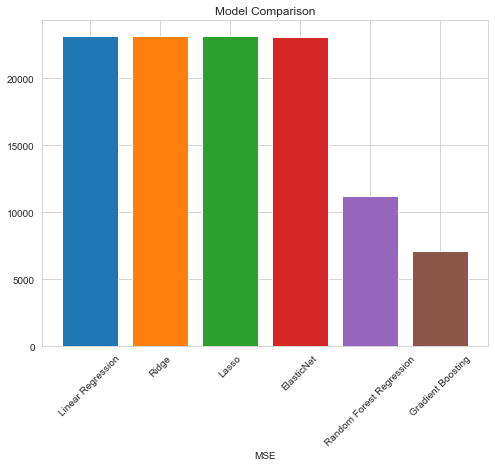

In [303]:
fig, ax = plt.subplots(figsize=(8, 6))
for name, metric in metrics.items():
    ax.bar(name, metric['MSE'])
ax.set_xlabel('MSE')
plt.xticks(rotation=45)
ax.set_title('Model Comparison')
plt.show()



In [ ]:
plt.bar()

## hyperparameter 

In [290]:
import pandas as pd
from sklearn.model_selection import train_test_split



# Create a smaller subset of the data
subset = price_df.sample(frac=1, random_state=42)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(subset.drop('payment_value', axis=1),
                                                    subset['payment_value'], 
                                                    test_size=0.3, 
                                                    random_state=42)


In [291]:
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

# Define the objective function for Optuna to optimize
def objective(trial):
    # Define the hyperparameters to optimize
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }
    
    # Create the model with the given hyperparameters
    model = GradientBoostingRegressor(**params)
    
    # Train the model and make predictions
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Compute the mean absolute error on the test set
    mae = mean_absolute_error(y_test, y_pred)
    
    return mae



In [ ]:
# import optuna
# from tqdm import tqdm

# def objective(trial):
#     # Define the hyperparameters to optimize
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 50, 200),
#         'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.5),
#         'max_depth': trial.suggest_int('max_depth', 2, 10),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
#         'subsample': trial.suggest_uniform('subsample', 0.5, 1),
#         'max_features': trial.suggest_uniform('max_features', 0.1, 1)
#     }

#     # Create a gradient boosting model with the given hyperparameters
#     model = GradientBoostingRegressor(**params)

#     # Fit the model with tqdm to monitor the progress
#     model.fit(X_train, y_train)

#     # Make predictions on the test set
#     y_pred = model.predict(X_test)

#     # Compute the metrics
#     mse = mean_squared_error(y_test, y_pred)

#     return mse

In [293]:
# # Run the hyperparameter search with tqdm to monitor the progress
# study = optuna.create_study(direction='minimize')
# with tqdm(total=10, desc='Optimizing', unit='%') as progress_bar:
#     study.optimize(objective, n_trials=10)
#     progress_bar.update(1)

In [294]:
study = optuna.create_study(direction='minimize')
with tqdm(total=5) as pbar:
    for i in range(5):
        study.optimize(objective, n_trials=10)
        pbar.update(1)

[I 2023-04-27 00:54:58,990] A new study created in memory with name: no-name-754d11e4-528e-417f-873f-ebbe9dffc222
  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\kevin\AppData\Local\Temp\ipykernel_38256\284204161.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
[I 2023-04-27 00:55:24,123] Trial 0 finished with value: 30.77992098439025 and parameters: {'n_estimators': 800, 'learning_rate': 0.18174749936081952, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 0 with value: 30.77992098439025.
C:\Users\kevin\AppData\Local\Temp\ipykernel_38256\284204161.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

In [308]:
# Print the best hyperparameters
best_params = study.best_params
print(f"Best parameters: {best_params}")

Best parameters: {'n_estimators': 500, 'learning_rate': 0.07114494530617727, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 1}


In [309]:
final_price_df = price_df
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_price_df.drop(columns=['payment_value']),final_price_df.payment_value, test_size=0.20,  random_state=42)


# Fit the model with the best hyperparameters to the full training set
model = GradientBoostingRegressor(**best_params)
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print('MAE:', mae)
print('MSE:', mse)
print('R2:', r2)

MAE: 24.787102328266247
MSE: 1851.3464111078852
R2: 0.8010757831097923


In [312]:
######################################
import matplotlib.pyplot as plt

# Assume y_test and y_pred are the actual and predicted values for test data
plt.scatter(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

TypeError: scatter() missing 1 required positional argument: 'y'

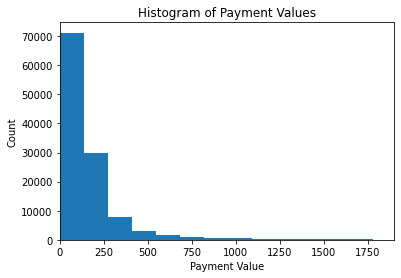

In [279]:
import matplotlib.pyplot as plt

# Plot a histogram of the payment values
plt.hist(price_df['payment_value'], bins=100)
plt.title('Histogram of Payment Values')
plt.xlabel('Payment Value')
plt.ylabel('Count')
plt.xlim(0, 1900)
plt.show()

<AxesSubplot:xlabel='payment_value', ylabel='Count'>

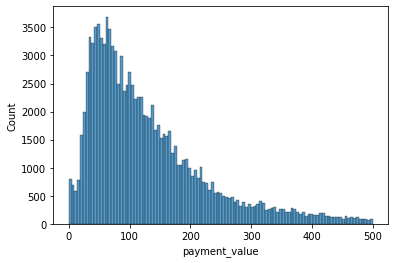

In [297]:
## now removing the outlier

sns.histplot(price_df['payment_value'])


<AxesSubplot:xlabel='payment_value', ylabel='Count'>

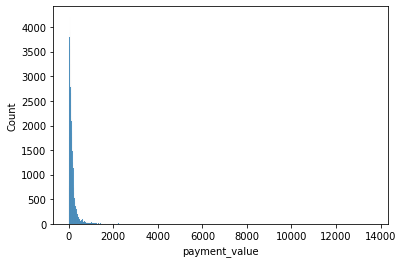

In [299]:
sns.histplot(merged_2['payment_value'])

In [305]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Define the objective function for Optuna to optimize
def objective_rf(trial):
    # Define the hyperparameters to optimize
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }
    
    # Create the model with the given hyperparameters
    model = RandomForestRegressor(**params)
    
    # Train the model and make predictions
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Compute the mean absolute error on the test set
    mae = mean_absolute_error(y_test, y_pred)
    
    return mae

# Create a study to optimize the objective function
study_rf = optuna.create_study(direction='minimize')



[I 2023-04-27 03:22:08,328] A new study created in memory with name: no-name-61849c79-398d-4f13-a0d5-f011f690ee41


In [306]:

with tqdm(total=5) as pbar:
    for i in range(5):
        study_rf.optimize(objective_rf, n_trials=5)
        pbar.update(1)

  0%|          | 0/5 [00:00<?, ?it/s][I 2023-04-27 03:25:27,403] Trial 0 finished with value: 31.399057789761148 and parameters: {'n_estimators': 800, 'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 1}. Best is trial 0 with value: 31.399057789761148.
[I 2023-04-27 03:25:37,326] Trial 1 finished with value: 34.356925623396045 and parameters: {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 0 with value: 31.399057789761148.
[I 2023-04-27 03:27:07,235] Trial 2 finished with value: 31.974458220612004 and parameters: {'n_estimators': 600, 'max_depth': 9, 'min_samples_split': 14, 'min_samples_leaf': 1}. Best is trial 0 with value: 31.399057789761148.
[I 2023-04-27 03:27:27,758] Trial 3 finished with value: 37.72271233842824 and parameters: {'n_estimators': 300, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 0 with value: 31.399057789761148.
[I 2023-04-27 03:29:48,588] Trial 4 finished with value: 

In [313]:
# Print the best hyperparameters
best_params_rf = study_rf.best_params
print(f"Best parameters: {best_params_rf}")

Best parameters: {'n_estimators': 700, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 5}


In [311]:
final_price_df = price_df
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_price_df.drop(columns=['payment_value']),final_price_df.payment_value, test_size=0.20,  random_state=42)


# Fit the model with the best hyperparameters to the full training set
model = GradientBoostingRegressor(**best_params_rf)
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print('MAE:', mae)
print('MSE:', mse)
print('R2:', r2)

MAE: 23.15630916628777
MSE: 1643.3590476779461
R2: 0.8234236933361668
